# Evaluation <a name = "Top"></a>

# Quick Links

<ol>
    <li><a href = #setup>Setup</a></li>
    <li><a href = #plots>Plots</a></li>
</ol>

## Imports

In [1]:
import os
import shutil

In [2]:
from datetime import datetime, timedelta
import time
import pandas as pd
import numpy as np
import shutil

from enum import Enum

from numpy import array

import ntpath

import copy
import re

## Hilfsfunktionen

### Enum für Trainingsset

In [3]:
class TrainingSet(Enum):
    SYNTHETIC = 1
    REAL = 2
    MIXED = 3

### Enum für Label-Typ

In [4]:
class LabelType(Enum):
    ANGULAR = 1
    STEREOGRAPHIC = 2

### Trainingsset-Typ nach String Converter

In [5]:
def trainingset_to_string(ts):
    if ts == TrainingSet.SYNTHETIC:
        return 'Synth'
    elif ts == TrainingSet.REAL:
        return 'Real'
    elif ts == TrainingSet.MIXED:
        return 'Mixed'
    else:
        print('Unknown TrainingSet')
        return None

### LabelType nach String

In [6]:
def labeltype_to_string(lt):
    if lt == LabelType.ANGULAR:
        return 'Angular'
    if lt == LabelType.STEREOGRAPHIC:
        return 'Stereographic'
    else:
        print('Unknown LabelType')
        return None

#### Required format of parameters parameter for _model_predict_ (...)

In [7]:
p = {
    'dataset_to_use':[],
    'model_to_load':[],
    'dataset_name':'dataset',
    'activation_function':[],
    'leaky_ReLU_alpha':[],
    'first_neuron':[],
    'dropout_rate':[],
    'hidden_layers':[],
    'optimizer':[],
    'learning_rate':[],
    'loss_function':[],
    'label_type':[]
}

## Hilfsfunktionen

### Konvertierung ($S_x$, $S_y$) $\rightarrow$ ($\phi$, $\theta$)

In [8]:
def convert_from_stereographic(sx, sy, r = 1):
    
    l = np.sqrt(sx * sx + sy * sy)
    theta = 90 - 2 * np.degrees(np.arctan(l / 2))
    
    if sx < 0:
        phi = 180 - np.degrees(np.arcsin(sy / l))
        
    elif sx >= 0:
        if sy > 0:
            phi = np.degrees(np.arcsin(sy / l))
        elif sy < 0:
            phi = 360 + np.degrees(np.arcsin(sy / l))
        else:
            #phi1 = np.NaN
            phi = 0
    else:
        print('sx and sy undefined. should not have reached here')

    return phi, theta

### Konvertierung ($\phi$, $\theta$) $\rightarrow$ ($S_x$, $S_y$)

In [9]:
def convert_from_spheric(phi, theta, r = 1):
    m = 2 * r * np.tan(np.radians((90 - theta) / 2))
    sy = m * np.sin(np.radians(phi))
    sx = m * np.cos(np.radians(phi))
    return sx, sy

### Radians $\rightarrow$ Degree

In [10]:
def to_degree(angle_in_rad):
    return angle_in_rad * 180 / np.pi

### Degree $\rightarrow$ Radians

In [11]:
def to_radians(angle_in_deg):
    return angle_in_deg * np.pi / 180

### Sphärische $\rightarrow$ Karthesische Koordinaten

In [12]:
def spheric_cartesian_polar(phi_d, theta_d):
    x = np.sin(np.radians(90.0 - theta_d)) * np.cos(np.radians(phi_d))
    y = np.sin(np.radians(90.0 - theta_d)) * np.sin(np.radians(phi_d))
    z = np.cos(np.radians(90.0 - theta_d))
    return array([x, y, z])

In [13]:
def spheric_cartesian_elevation(phi_d, theta_d):
    x = np.cos(np.radians(theta_d)) * np.cos(np.radians(phi_d))
    y = np.cos(np.radians(theta_d)) * np.sin(np.radians(phi_d))
    z = np.sin(np.radians(theta_d))
    return array([x, y, z])

### Length of Vector

In [14]:
def vectorlength(vector):
    return np.linalg.norm(vector)

### Calculated Angular Error

In [15]:
def calculate_angular_error(deg_e_phi, deg_e_theta):
    return np.degrees(np.arccos(np.cos(np.radians(deg_e_phi)) * np.cos(np.radians(deg_e_theta))))

### Skalarprodukt

In [16]:
def myDot(a, b):
    dot = 0;
    it = np.nditer(a, flags=['f_index'])
    for x in it:
        dot = dot + (x * b[it.index])
        
    return dot

### Dot Angular Error

In [17]:
def dot_angular_error_elevation(predicted_deg_vector, true_deg_vector):    
    c_predicted = spheric_cartesian_elevation(predicted_deg_vector[0], predicted_deg_vector[1])
    c_true = spheric_cartesian_elevation(true_deg_vector[0], true_deg_vector[1])
    
    len_prediction = vectorlength(c_predicted)
    len_true = vectorlength(c_true)
    
    cos_angle = np.dot(c_true, c_predicted) / len_prediction / len_true
    
    return abs(np.degrees(np.arccos(cos_angle)))

def dot_angular_error_polar(predicted_deg_vector, true_deg_vector):
    c_predicted = spheric_cartesian_polar(predicted_deg_vector[0], predicted_deg_vector[1])
    c_true = spheric_cartesian_polar(true_deg_vector[0], true_deg_vector[1])
    
    len_prediction = vectorlength(c_predicted)
    len_true = vectorlength(c_true)
    
    cos_angle = np.dot(c_true, c_predicted) / len_prediction / len_true
    
    return abs(np.degrees(np.arccos(cos_angle)))

## Normierte sphärische Koordinaten

### Normierte $\rightarrow$ Sphärische

In [18]:
def normalized_to_spheric(n_phi, n_theta):
    phi = n_phi * 180 + 180
    theta = n_theta * 45 + 45
    
    return phi, theta

# Evaluation <a name = "setup"></a>
<p><a href = #Top>Up</a>
<p><a href = #plots>Plots</a>

In [19]:
run = 'SYNTH'
nets = ['ALEX','VGG16','RESNET'] # ALEX, VGG16, RESNET, prevVGG16, prevRESNET
image_channels = ['rgb', 'rgba'] #rgb vs rgbd
dataset = '201129_2031'

eval_dir = '..\\output\\Regression\\'#''.format(net, image_channels)

if(not os.path.exists(eval_dir)):
    os.makedirs(eval_dir)
else:
    input('Directory >>| {} |<< existiert bereits. Fortsetzen auf eigene Gefahr! (Weiter mit Enter)'.format(eval_dir))

Directory >>| ..\output\Regression\ |<< existiert bereits. Fortsetzen auf eigene Gefahr! (Weiter mit Enter)


In [29]:
#import pickle

net_results = [None, None, None,  None, None,  None]
# ALEX-rgb ALEX_rgba RESNET_rgb RESNET_rgba
k=0
for i in range(3):
    for j in range(2):
        csv = '..\\output\\{}_{}_{}\\Evaluation_SYNTH\\Prognosen.csv'.format(nets[i], dataset, image_channels[j])
        df = pd.read_csv(csv)
        net_results[k] = df['dot_angular_err_elevation']
        k +=1

In [30]:
for i in range(4):
    print(net_results)
    print()
    print()
    print('---------------------------------------------------------------------')
    print()
    print()

[0        6.662339
1        7.107387
2        5.319884
3        5.435905
4        6.116244
          ...    
9995     9.400343
9996    11.772140
9997     9.450229
9998     7.253502
9999     5.926976
Name: dot_angular_err_elevation, Length: 10000, dtype: float64, 0        4.806328
1        4.101333
2        8.032171
3        0.072342
4        6.381275
          ...    
9995    11.794260
9996     3.439693
9997    30.147272
9998     3.913873
9999    15.317806
Name: dot_angular_err_elevation, Length: 10000, dtype: float64, 0       4.078609
1       0.592889
2       3.487280
3       1.609291
4       3.064289
          ...   
9995    2.241300
9996    4.103546
9997    2.492697
9998    3.057382
9999    1.810499
Name: dot_angular_err_elevation, Length: 10000, dtype: float64, 0       1.892283
1       0.755198
2       2.897037
3       0.546867
4       1.287190
          ...   
9995    3.762196
9996    4.909185
9997    1.747860
9998    2.160311
9999    6.148678
Name: dot_angular_err_elevation, Leng

In [31]:
import matplotlib.pyplot as plt
import matplotlib.text as text
from matplotlib.pyplot import figure

from matplotlib import cm

import tikzplotlib
%matplotlib inline

Enable_Plotting = True

In [32]:
#pip install tikzplotlib

# Plots <a name = "plots">
<p></a><a href = #Top>Up</a>
<p><a href = #setup>Setup</a>

##  Plot Box-Whisker-Diagram

In [44]:
def do_Plot(title, eval_file, save = True):
    plt.rcParams.update({'font.size': 14})
    fig, ax = plt.subplots(figsize = (15,15))
    
    pos = [1, 2, 3, 4, 5, 6]    
    w = [0.5,0.5,0.5,0.5,0.5,0.5]
    
    cmap = cm.get_cmap('tab20c')
    #colours = [cmap(0.), cmap(0.05), cmap(0.1), cmap(0.15), cmap(0.2), cmap(0.25), cmap(0.3), cmap(0.35)]
    colours = [cmap(0.), cmap(0.05), cmap(0.1), cmap(0.15), cmap(0.2), cmap(0.25)]
    #colours = [cmap(0.1), cmap(0.3), cmap(0.5), cmap(0.7)]
    
    p1 = plt.boxplot(net_results, positions = pos, widths = w, showmeans = True, meanline = True, patch_artist = True, 
                     boxprops = dict(facecolor = colours[0]))
    lbls = [
        'AlexNet \n RGB', 
        'AlexNet \n RGBD',  
        'VGG16 \n RGB', 
        'VGG16 \n RGBD',
        'ResNet \n RGB',
        'ResNet \n RGBD'
    ]
    plt.xticks(pos, lbls)

    #plt.setp(ax.get_xticklabels(), rotation = 'vertical')
    plt.ylabel('Distribution of\nthe angular error')
    plt.title(title)
    ax.grid(True, ls = '--', axis = 'y')
    
    plots = [p1]
    for p in plots:
        caps = p['caps']
        for cap in caps:
            cap.set(xdata = cap.get_xdata() + (-.075, +.075))
    
    #start, end = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(-10, 170, 10))
    
    for o in fig.findobj(text.Text):
        #o.set_fontstyle('italic')
        o.set_size(20)
    
    if(save):
        tikzplotlib.save('{}.tex'.format(eval_file))
        #plt.savefig('{}.png'.format(eval_file), format = 'png', bbox_inches = "tight", transparent=False, dpi = 300)
    plt.savefig('..\\output\\Diagrams\\Boxplot.png', dpi=600, bbox_inches='tight')
    plt.show()

### Show Plot

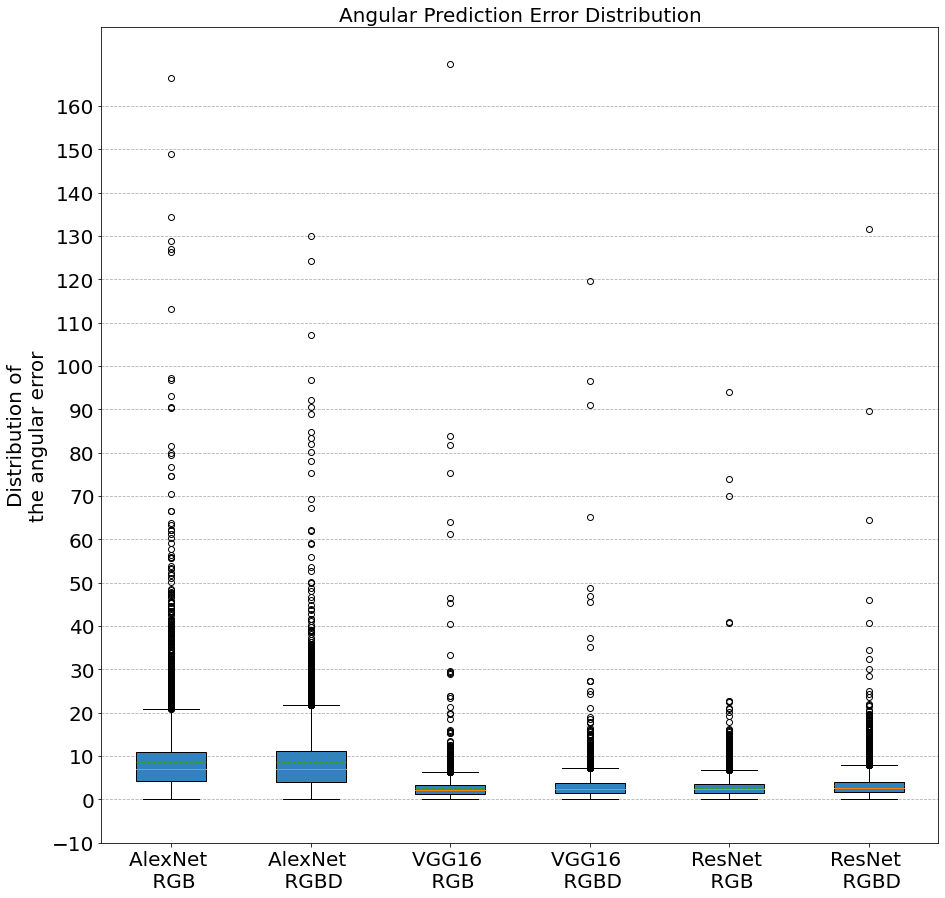

In [45]:
if Enable_Plotting:
    tsts_plot = do_Plot('Angular Prediction Error Distribution', eval_dir + 'Box-Whisker-Plot')
    